In [1]:
from __future__ import division
import numpy as np
from data_reader import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import copy

import picos as pic
import cvxopt as cvx
%matplotlib inline



In [2]:
'''Read data'''
warning_path = 'data/warnings/'
warning_name = '05182017.csv'
warnings_05182017 = read_data(warning_path+warning_name)
warnings_05182017 = warnings_05182017[28:27655+28,:]
print(warnings_05182017.shape)

warning_name = '10152017.csv'
warnings_10152017 = read_data(warning_path+warning_name)
print(warnings_10152017.shape)

warning_name = '10172017.csv'
warnings_10172017 = read_data(warning_path+warning_name)
print(warnings_10172017.shape)

warning_name = '10172017_freeway.csv'
warnings_10172017_freeway = read_data(warning_path+warning_name)
print(warnings_10172017_freeway.shape)

anomaly_path = 'data/anomalies/'
anomaly_name = '05182017.csv'
anomalies_05182017 = read_data(anomaly_path+anomaly_name)
print(anomalies_05182017.shape)

anomaly_name = '10152017.csv'
anomalies_10152017 = read_data(anomaly_path+anomaly_name)
print(anomalies_10152017.shape)

anomaly_name = '10172017.csv'
anomalies_10172017 = read_data(anomaly_path+anomaly_name)
print(anomalies_10172017.shape)

anomaly_name = '10172017_freeway.csv'
anomalies_10172017_freeway = read_data(anomaly_path+anomaly_name)
print(anomalies_10172017_freeway.shape)

(27655, 18)
(19137, 18)
(40646, 18)
(79585, 18)
(27655, 5)
(19137, 5)
(40646, 5)
(79585, 5)


In [3]:
'''concate data'''
warnings = np.vstack([warnings_05182017, warnings_10152017, warnings_10172017, warnings_10172017_freeway])
anomalies = np.vstack([anomalies_05182017, anomalies_10152017, anomalies_10172017, anomalies_10172017_freeway])
print(warnings.shape)
print(anomalies.shape)

(167023, 18)
(167023, 5)


In [4]:
'''Read and process the warning signals'''
FCW = warnings[:,1].astype(int)# Forward Collision Warning
LLDW = warnings[:,2].astype(int) # Left Lane Departure Warning
RLDW = warnings[:,3].astype(int) # Right Lane Departure Warning
LDW = LLDW|RLDW 
FSW = warnings[:,4].astype(int) # FailSafe Warning
FSType = warnings[:,5].astype(int) # FailSafe Types

LCrossing = warnings[:,7]
RCrossing = warnings[:,8]
LCutIn = warnings[:,9]
RCutIn = warnings[:,10]

In [5]:
'''Compute probabilities of Warning variables, as value of data'''
three_warnings = np.hstack([np.reshape(FCW,(len(FCW),1)),np.reshape(LDW,(len(LDW),1)),np.reshape(FSW,(len(FSW),1))])
states_list,state_counts = np.unique(three_warnings,axis=0,return_counts=True)
print (states_list)
print (state_counts)
p_list = state_counts/three_warnings.shape[0]
print (p_list)
value_list = -np.log2(p_list)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]
[162096   4028    747    152]
[  9.70501069e-01   2.41164391e-02   4.47243793e-03   9.10054304e-04]


In [6]:
'''Utilities'''
def gaussian_func(x,a,mu,sigma):
    return a*np.exp(-((x-mu)**2)/(2*sigma**2))
def score_filter(raw_score,sigma):
    j = 0
    N = raw_score.shape[0]
    filtered_score = copy.deepcopy(raw_score)
    for i,score in enumerate(raw_score):
        if j > 0:
            if raw_score[j] > raw_score[j-1]:
                mu = j
                start_idx = np.max([mu - 3*sigma,0])
                a = raw_score[j] - raw_score[j-1]
                for k in range(start_idx,mu):
                    filtered_score[k] = np.max([filtered_score[k],gaussian_func(k,a,mu,sigma)])
            elif raw_score[j] < raw_score[j-1]:
                mu = j
                end_idx = np.min([mu + 3*sigma,N])
                a = raw_score[j-1] - raw_score[j]
                for k in range(mu,end_idx):
                    filtered_score[k] = np.max([filtered_score[k],gaussian_func(k,a,mu,sigma)])
        j += 1
    return filtered_score

def compute_raw_score(states_list,state,value_list):
    tmp_i = np.where((states_list == state).all(axis=1))[0]
    return value_list[tmp_i]

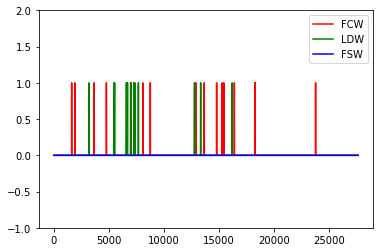

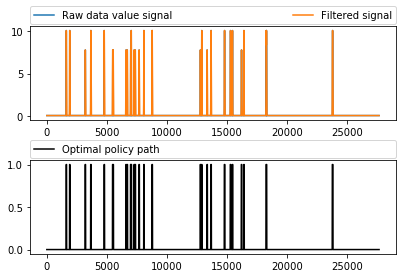

In [9]:
'''Run moving horizon optimization'''

buf_size = 500
eta = 5
zeta = 10
sigma = 10
memo_max = 2000000
moving_buf = {}
moving_buf['size'] = []
moving_buf['value'] = []
moving_buf['state'] = []
optimal_policy = []
k = 0
memo_tracker = 0
all_filtered_scores = []
all_raw_scores = []
test_data = three_warnings[0:27655,:]#[6500:8500,:]#[47000:47500,:]#[15200:15400,:]
num_data = test_data.shape[0]

for i,state in enumerate(test_data):
    moving_buf['state'].append(test_data[i,:])
    moving_buf['value'].append(compute_raw_score(states_list,test_data[i,:],value_list))
    moving_buf['size'].append(float(2*np.random.randn(1)+10)) # assume the img size follows a normal distribution
    if len(moving_buf['value']) == buf_size or i == num_data-1: # start to optimize if buffer is full or there is no new frame
        buf_length = len(moving_buf['value'])
        '''Filter the score'''
        filtered_score = score_filter(np.array(moving_buf['value']), sigma)
        
        '''Init the MIQP problem'''
        prob = pic.Problem()
        pi  = [prob.add_variable(str(j),1, vtype='binary') for j in range(buf_length)]
        size = pic.new_param('size',moving_buf['size'])
        value = pic.new_param('value',filtered_score)
        
        '''Add objective function'''
        obj_func = (size[0]-eta*value[0])*pi[0]
        for j in range(1,buf_length):
            obj_func += (size[j]-eta*value[j])*pi[j] + zeta * (pi[j]-pi[j-1])**2
        prob.set_objective('min', obj_func)
        
        '''Add constraint'''
        prob.add_constraint( pic.sum([size[j]*pi[j] for j in range(buf_length)], #summands
                            'j',                            #name of the index
                            '[buf_length]'                           #set to which the index belongs
                           ) < np.max([memo_max - memo_tracker,0])
                   )
        '''Solve'''
        sol = prob.solve(solver='gurobi', verbose = 0)
        sorted_action = [float(policy.value[0]) for policy in pi]

        '''Save data, update storage capacity'''
        memo_tracker += float(np.dot(sorted_action,np.array(moving_buf['size'])))
        
        '''Append the sorted action to the whole action list'''
        if k == 0:
            optimal_policy = sorted_action
            all_filtered_scores = filtered_score
            all_raw_scores = np.array(moving_buf['value'])
        else:
            optimal_policy = np.append(optimal_policy, sorted_action)
            all_filtered_scores = np.append(all_filtered_scores, filtered_score)
            all_raw_scores = np.append(all_raw_scores, np.array(moving_buf['value']))
            
        k += 1
        moving_buf['size'] = []
        moving_buf['value'] = []
        moving_buf['state'] = []

plt.figure(1)
plt.plot(test_data[:,0],'r')
plt.plot(test_data[:,1],'g')
plt.plot(test_data[:,2],'b')
plt.ylim([-1,2])
plt.legend(['FCW','LDW','FSW'])

plt.figure(2)
plt.subplot(211)
plt.plot(all_raw_scores)
plt.plot(all_filtered_scores)
plt.legend(['Raw data value signal', 'Filtered signal'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('data_value_signal.png',dpi=500)

# plt.figure(3)
plt.subplot(212)
plt.plot(optimal_policy,'k')
plt.legend(['Optimal policy path'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout(pad=2)
# plt.savefig('value_and_policy_MIQP.png',dpi=500)


<function matplotlib.pyplot.show>

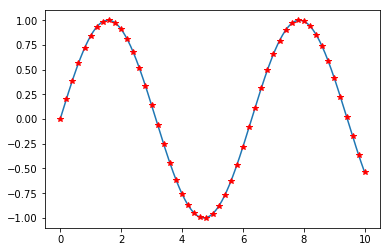

In [7]:
'''sampling and reconstruction'''
w = 100 # original frequency in Hz
w_sample = 5 # sample rate
time = np.arange(0,10,1/w)
x = np.sin(time)
sample_x = []
sample_time = []
for i,sample in enumerate(x):
    if i%(w/w_sample) ==0:
        sample_x.append(sample)
        sample_time.append(time[i])
        
sample_x.append(x[-1])
sample_time.append(time[-1])  

plt.plot(time,x)
plt.plot(sample_time,sample_x,'r*')
plt.show



0.665676243854


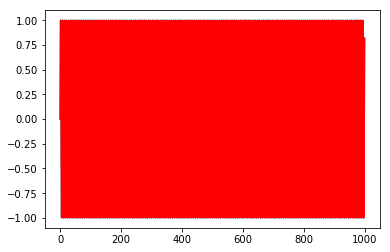

In [53]:
# linear interpolation
reconstructed_x = []
reconstructed_t = []
for i,sample in enumerate(sample_x):
    if i+1 == len(sample_x):
        break
    next_sample = sample_x[i+1]
    interpolate_x = sample + [(next_sample-sample)*(j*w_sample/w) for j in range(int(w/w_sample))]
    interpolate_t = sample_time[i] + [(1/w)*j for j in range(int(w/w_sample))]
    if i == 0:
        reconstructed_x = interpolate_x
        reconstructed_t = interpolate_t
    else:
        reconstructed_x = np.append(reconstructed_x,interpolate_x)
        reconstructed_t = np.append(reconstructed_t,interpolate_t)
plt.plot(time,x)
plt.plot(reconstructed_t,reconstructed_x,'r*')
plt.show

# compute reconstruction error
error = np.dot((reconstructed_x - x),(reconstructed_x - x))
print(error)

(1000,)